In [109]:
!pip install keras

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras


class ForecastLSTM:
    def __init__(self, random_seed: int = 1234):
        self.random_seed = random_seed

## Make def

In [111]:
def reshape_dataset(self, df: pd.DataFrame) -> np.array:
    # y 컬럼을 데이터프레임의 맨 마지막 위치로 이동
    if "y" in df.columns:
        df = df.drop(columns=["y"]).assign(y=df["y"])
    else:
        raise KeyError("Not found target column 'y' in dataset.")
    
    # shape 변경
    dataset = df.values.reshape(df.shape)
    return dataset

ForecastLSTM.reshape_dataset = reshape_dataset

In [112]:
def split_sequences(
    self, dataset: np.array, seq_len: int, steps: int, single_output: bool
) -> tuple:

    # feature와 y 각각 sequential dataset을 반환할 리스트 생성
    X, y = list(), list()
    # sequence length와 step에 따라 sequential dataset 생성
    for i, _ in enumerate(dataset):
        idx_in = i + seq_len
        idx_out = idx_in + steps
        if idx_out > len(dataset):
            break
        seq_x = dataset[i:idx_in, :-1]
        if single_output:
            seq_y = dataset[idx_out - 1 : idx_out, -1]
        else:
            seq_y = dataset[idx_in:idx_out, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


ForecastLSTM.split_sequences = split_sequences

In [113]:
def split_train_valid_dataset(
    self,
    df: pd.DataFrame,
    seq_len: int,
    steps: int,
    single_output: bool,
    validation_split: float = 0.3,
    verbose: bool = True,
) -> tuple:
    # dataframe을 numpy array로 reshape
    dataset = self.reshape_dataset(df=df)

    # feature와 y를 sequential dataset으로 분리
    X, y = self.split_sequences(
        dataset=dataset,
        seq_len=seq_len,
        steps=steps,
        single_output=single_output,
    )

    # X, y에서 validation dataset 분리
    dataset_size = len(X)
    train_size = int(dataset_size * (1 - validation_split))
    X_train, y_train = X[:train_size, :], y[:train_size, :]
    X_val, y_val = X[train_size:, :], y[train_size:, :]
    if verbose:
        print(f" >>> X_train: {X_train.shape}")
        print(f" >>> y_train: {y_train.shape}")
        print(f" >>> X_val: {X_val.shape}")
        print(f" >>> y_val: {y_val.shape}")
    return X_train, y_train, X_val, y_val


ForecastLSTM.split_train_valid_dataset = split_train_valid_dataset

In [114]:
def build_and_compile_lstm_model(
    self,
    seq_len: int,
    n_features: int,
    lstm_units: list,
    learning_rate: float,
    dropout: float,
    steps: int,
    metrics: str,
    single_output: bool,
    last_lstm_return_sequences: bool = False,
    dense_units: list = None,
    activation: str = None,
):
    """
    LSTM 네트워크를 생성한 결과를 반환한다.

    :param seq_len: Length of sequences. (Look back window size)
    :param n_features: Number of features. It requires for model input shape.
    :param lstm_units: Number of cells each LSTM layers.
    :param learning_rate: Learning rate.
    :param dropout: Dropout rate.
    :param steps: Length to predict.
    :param metrics: Model loss function metric.
    :param single_output: Whether 'yhat' is a multiple value or a single value.
    :param last_lstm_return_sequences: Last LSTM's `return_sequences`. Allow when `single_output=False` only.
    :param dense_units: Number of cells each Dense layers. It adds after LSTM layers.
    :param activation: Activation function of Layers.
    """
    tf.random.set_seed(self.random_seed)
    model = Sequential()

    if len(lstm_units) > 1:
        # LSTM -> ... -> LSTM -> Dense(steps)
        model.add(
            LSTM(
                units=lstm_units[0],
                activation=activation,
                return_sequences=True,
                input_shape=(seq_len, n_features),
            )
        )
        lstm_layers = lstm_units[1:]
        for i, n_units in enumerate(lstm_layers, start=1):
            if i == len(lstm_layers):
                if single_output:
                    return_sequences = False
                else:
                    return_sequences = last_lstm_return_sequences
                model.add(
                    LSTM(
                        units=n_units,
                        activation=activation,
                        return_sequences=return_sequences,
                    )
                )
            else:
                model.add(
                    LSTM(
                        units=n_units,
                        activation=activation,
                        return_sequences=True,
                    )
                )
    else:
        # LSTM -> Dense(steps)
        if single_output:
            return_sequences = False
        else:
            return_sequences = last_lstm_return_sequences
        model.add(
            LSTM(
                units=lstm_units[0],
                activation=activation,
                return_sequences=return_sequences,
                input_shape=(seq_len, n_features),
            )
        )

    if single_output:  # Single Step, Direct Multi Step
        if dense_units:
            for n_units in dense_units:
                model.add(Dense(units=n_units, activation=activation))
        if dropout > 0:
            model.add(Dropout(rate=dropout))
        model.add(Dense(1))
    else:  # Multiple Output Step
        if last_lstm_return_sequences:
            model.add(Flatten())
        if dense_units:
            for n_units in dense_units:
                model.add(Dense(units=n_units, activation=activation))
        if dropout > 0:
            model.add(Dropout(rate=dropout))
        model.add(Dense(units=steps))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=MSE, metrics=metrics)
    return model


ForecastLSTM.build_and_compile_lstm_model = build_and_compile_lstm_model

In [115]:
def fit_lstm(
    self,
    df: pd.DataFrame,
    steps: int,
    lstm_units: list,
    activation: str,
    dropout: float = 0,
    seq_len: int = 16,
    single_output: bool = False,
    epochs: int = 200,
    batch_size: int = None,
    steps_per_epoch: int = None,
    learning_rate: float = 0.001,
    patience: int = 10,
    validation_split: float = 0.3,
    last_lstm_return_sequences: bool = False,
    dense_units: list = None,
    metrics: str = "acc",
    check_point_path: str = None,
    verbose: bool = False,
    plot: bool = True,
):
    """
    LSTM 기반 모델 훈련을 진행한다.

    :param df: DataFrame for model train.
    :param steps: Length to predict.
    :param lstm_units: LSTM, Dense Layers
    :param activation: Activation function for LSTM, Dense Layers.
    :param dropout: Dropout ratio between Layers.
    :param seq_len: Length of sequences. (Look back window size)
    :param single_output: Select whether 'y' is a continuous value or a single value.
    """

    np.random.seed(self.random_seed)
    tf.random.set_seed(self.random_seed)

    # 훈련, 검증 데이터셋 생성
    (
        self.X_train,
        self.y_train,
        self.X_val,
        self.y_val,
    ) = self.split_train_valid_dataset(
        df=df,
        seq_len=seq_len,
        steps=steps,
        validation_split=validation_split,
        single_output=single_output,
        verbose=verbose,
    )

    # LSTM 모델 생성
    n_features = df.shape[1] - 1
    self.model = self.build_and_compile_lstm_model(
        seq_len=seq_len,
        n_features=n_features,
        lstm_units=lstm_units,
        activation=activation,
        learning_rate=learning_rate,
        dropout=dropout,
        steps=steps,
        last_lstm_return_sequences=last_lstm_return_sequences,
        dense_units=dense_units,
        metrics=metrics,
        single_output=single_output,
    )

    # 모델 적합 과정에서 best model 저장
    if check_point_path is not None:
        # create checkpoint
        checkpoint_path = f"checkpoint/lstm_{check_point_path}.h5"
        checkpoint = ModelCheckpoint(
            filepath=checkpoint_path,
            save_weights_only=False,
            save_best_only=True,
            monitor="val_loss",
            verbose=verbose,
        )
        rlr = ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=patience, verbose=verbose
        )
        callbacks = [checkpoint, EarlyStopping(patience=patience), rlr]
    else:
        rlr = ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=patience, verbose=verbose
        )
        callbacks = [EarlyStopping(patience=patience), rlr]

    # 모델 훈련
    self.history = self.model.fit(
        self.X_train,
        self.y_train,
        batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_data=(self.X_val, self.y_val),
        epochs=epochs,
        use_multiprocessing=True,
        workers=8,
        verbose=verbose,
        callbacks=callbacks,
        shuffle=False,
    )

    # 훈련 종료 후 best model 로드
    if check_point_path is not None:
        self.model.load_weights(f"checkpoint/lstm_{check_point_path}.h5")

    # 모델링 과정 시각화
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(self.history.history[f"{metrics}"])
        plt.plot(self.history.history[f"val_{metrics}"])
        plt.title("Performance Metric")
        plt.xlabel("Epoch")
        plt.ylabel(f"{metrics}")
        if metrics == "mape":
            plt.axhline(y=10, xmin=0, xmax=1, color="grey", ls="--", alpha=0.5)
        plt.legend(["Train", "Validation"], loc="upper right")
        plt.show()


ForecastLSTM.fit_lstm = fit_lstm

In [116]:
def forecast_validation_dataset(self) -> pd.DataFrame:
    # 검증 데이터셋의 실제 값(y)과, 예측 값(yhat)을 저장할 리스트 생성
    y_pred_list, y_val_list = list(), list()
    
    # 훈련된 모델로 validation dataset에 대한 예측값 생성
    for x_val, y_val in zip(self.X_val, self.y_val):
        x_val = np.expand_dims(
            x_val, axis=0
        )  # (seq_len, n_features) -> (1, seq_len, n_features)
        y_pred = self.model.predict(x_val)[0]
        y_pred_list.extend(y_pred.tolist())
        y_val_list.extend(y_val.tolist())
    return pd.DataFrame({"y": y_val_list, "yhat": y_pred_list})


ForecastLSTM.forecast_validation_dataset = forecast_validation_dataset

In [117]:
def calculate_metrics(df_fcst: pd.DataFrame) -> dict:
    true = df_fcst["y"]
    pred = df_fcst["yhat"]

    mae = (true - pred).abs().mean()
    mape = (true - pred).abs().div(true).mean() * 100
    mse = ((true - pred) ** 2).mean()
    

    l=len(pred)
    score = sum([np.round(pred[i])==true[i] for i in range(l)])/l
    accuracy = score*100
    
    return {
        "mae": mae,
        "mape": mape,
        "mse": mse,
        "acc": accuracy,
    }

## Dataset

In [118]:
df=pd.read_csv('./(block) ton_memory.csv')
df

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,CMD,label,type
0,1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,Web-Content,0,normal
1,1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,firefox,0,normal
2,1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,Xorg,0,normal
3,1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,update-manager,0,normal
4,1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,nautilus,0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,atop,1,dos
9996,1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,dbus-daemon,1,dos
9997,1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,irqbalance,1,dos
9998,1556219663,2576,0,0,121,22308.0,640.0,0.0,0.0,0.00,upstart-dbus-b,1,dos


In [119]:
#drop string
df = df.drop(['CMD','type'], axis=1)
df

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,label
0,1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,0
1,1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,0
2,1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,0
3,1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,0
4,1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,1
9996,1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,1
9997,1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,1
9998,1556219663,2576,0,0,121,22308.0,640.0,0.0,0.0,0.00,1


In [120]:
#위 함수에서 라벨을 'y'로 설정해줬기 때문에, 데이터 셋에서 'label'을 'y'로 바꿔줌
df.rename(columns={'label':'y'}, inplace=True)
df

,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,y
0,1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,0
1,1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,0
2,1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,0
3,1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,0
4,1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,1
9996,1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,1
9997,1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,1
9998,1556219663,2576,0,0,121,22308.0,640.0,0.0,0.0,0.00,1


In [121]:
df.iloc[7000:7001,:1]

,ts
7000,1556209263


In [122]:
cutoff = 1556209263

In [123]:
df = df.set_index('ts')
df

,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM,y
ts,,,,,,,,,,
1554218915,3257,859502,54,193,2.0,519.1,2.0,519.1,0.14,0
1554218920,3197,247354,95,193,2.6,402.0,2.6,402.0,0.11,0
1554218925,1442,57311,33,2219,764.2,290.7,764.2,290.7,0.08,0
1554218930,3119,68006,17,3063,725.9,116.8,725.9,116.8,0.03,0
1554218935,2797,72300,69,1350,1.4,109.6,1.4,109.6,0.03,0
...,...,...,...,...,...,...,...,...,...,...
1556219648,3293,1912,0,148,17624.0,2372.0,0.0,0.0,0.00,1
1556219653,2499,0,0,415,40184.0,2288.0,0.0,0.0,0.00,1
1556219658,1401,3,0,36,19296.0,824.0,0.0,0.0,0.00,1


## Experiment

In [124]:
## 1) Train, Test 데이터 분리
df_train = df[df.index < cutoff]
df_test = df[df.index >= cutoff]

In [125]:
## 2) Sequence Length, 예측 기간(Step), Single Output 여부 등 정의


seq_len = 40  # 과거 5개의 데이터를 feature로 사용
steps = 40  # 향후 5개의 y를 예측
single_output = False  # 향후 5개의 시점만이 아닌, 1~5개 모두 예측


metrics = "acc"  # 모델 성능 지표

In [126]:
## 3) LSTM 하이퍼파라미터 정의
lstm_params = {
    "seq_len": seq_len,
    "epochs": 300,  # epochs 반복 횟수
    "patience": 30,  # early stopping 조건
    "steps_per_epoch": 5,  # 1 epochs 시 dataset을 5개로 분할하여 학습
    "learning_rate": 0.01,
    "lstm_units": [64, 32],  # Dense Layer: 2, Unit: (64, 32)
    "activation": "relu",
    "dropout": 0,
    "validation_split": 0.3,  # 검증 데이터셋 30%
}

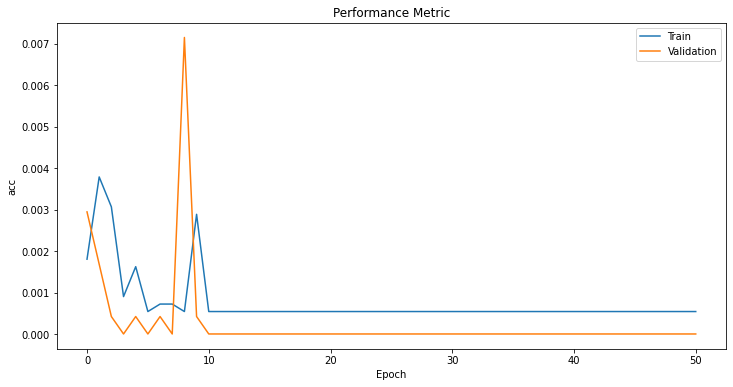

In [127]:
## 4) 모델 훈련
fl = ForecastLSTM()
fl.fit_lstm(
    df=df_train,
    steps=steps,
    single_output=single_output,
    metrics=metrics,
    **lstm_params,
)

In [128]:
## 5) Validation dataset 예측 성능
df_fcst_val = fl.forecast_validation_dataset()


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


In [129]:
val_loss = calculate_metrics(df_fcst=df_fcst_val)[metrics]
print(f"{metrics} of validation dataset: {val_loss.round(3)}")

acc of validation dataset: 78.253
